This notebook is for developing suplemental figure 4.

It works together with scripts "deploy_shuffle_clustering.py" and "run_shuffle_clustering.py" which are in vba repo, to generate shuffled datasets, coclustering matrices and labels for each type of shuffle.

For the scope of supplemental figure 4, I will only use "experience" and "experience_within_cell" shuffle types for figures.

Making SSE figures. 



In [3]:
import os
import numpy as np

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import seaborn as sns

sns.set_context('notebook', font_scale=1, rc={'lines.markeredgewidth': 1})



In [4]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [6]:
import visual_behavior.visualization.utils as utils
import visual_behavior_glm.GLM_analysis_tools as gat

palette_experience = utils.get_experience_level_colors()
palette_cre = utils.get_cre_line_colors()

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [8]:

# # load experiments table
experiments_table = loading.get_platform_paper_experiment_table()
# # limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)


3921 cells in matched cells table


In [13]:
figsizes = [(20,7), (10,7), (20,7)]
thresholds = [0.10]

In [10]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [11]:
# set params for saving
folder = '220817_SSE_general'
file_dir = '220627_shuffle_test/files'

In [14]:
base_dir = r'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [15]:
# create folder to load and save to
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

#### Load original feature matrix,, meta data and cluster labels

In [16]:
filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(base_dir,file_dir, filename), key='df')

In [17]:
filename = 'cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5'
df_meta = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [18]:
filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
original_cluster_labels = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [19]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line].index.values
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

In [20]:
original_cluster_labels.head(2)

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2


#### compute mean dropout scores for original data

In [21]:
cre_mean_dropout_scores = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df)
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    if cre_line == 'Slc17a7-IRES2-Cre':
        print('changing stuff')
        mean_dropout_scores=mean_dropout_scores.rename(columns= {4:5,5:4})
        mean_dropout_scores = mean_dropout_scores.reindex(sorted(mean_dropout_scores), axis=1)
    cre_mean_dropout_scores[cre_line] = mean_dropout_scores

changing stuff


In [22]:
original_min_max = {}
for cre_line in cre_lines:
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    min_cluster = cluster_df[['cluster_id']].value_counts().min()
    max_cluster = cluster_df[['cluster_id']].value_counts().max()
    original_min_max[cre_line] = [min_cluster, max_cluster]

    print(100/len(cluster_df)*min_cluster)
    print(100/len(cluster_df)*max_cluster)

3.23653962492438
22.081064730792498
3.0
33.0
2.6506024096385543
22.40963855421687


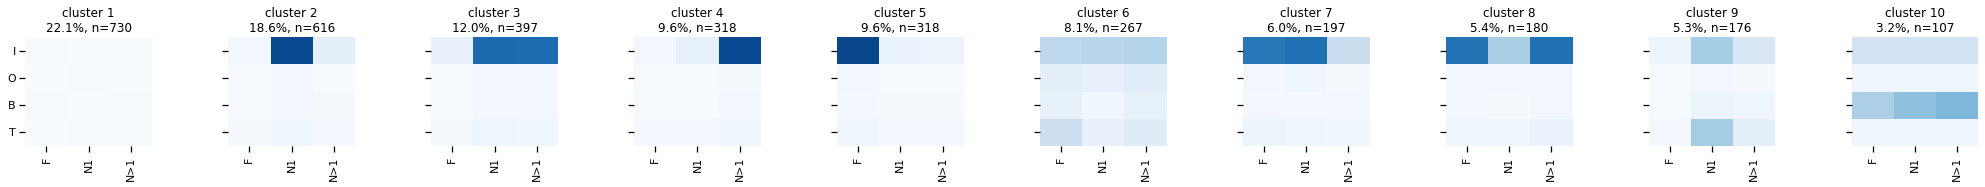

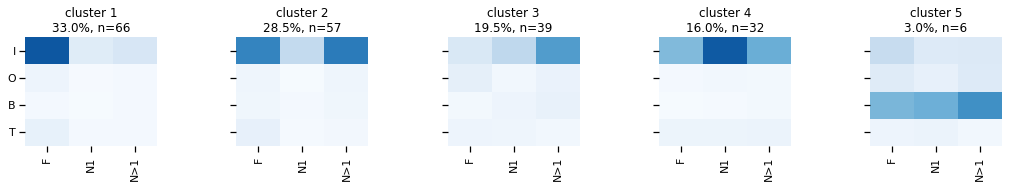

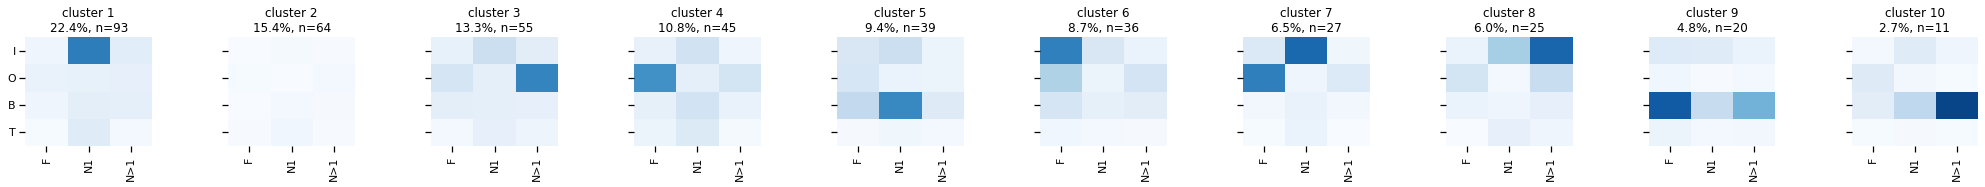

In [23]:
# plot original clusters
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_original',
                                )


#### load shuffled datasets into one dictionary

In [24]:
shuffle_types = ['experience', 'experience_within_cell','full_experience']
# randomize 150 samples of shuffled data
# n_boots = np.random.randint(0, 500, 150)
n_boots = np.arange(500)

#### load cluster labels for each dataset into one dictionary

In [25]:
%%time
shuffle_type_labels = {}
for shuffle_type in shuffle_types:
    cre_labels_shuffled = {}
    for cre_line in cre_lines:
        nb_labels_shuffled = {}                       
        for n, n_boot in enumerate(n_boots):
            nb_filename ='{}_{}_nb{}_cluster_labels.h5'.format(cre_line, shuffle_type, n_boot) 
            full_filename = os.path.join(base_dir, file_dir, nb_filename)
            nb_labels_shuffled[n] = pd.read_hdf(full_filename, key = 'clustered_df')
        
        #print(shuffle_type, cre_line, index)
        cre_labels_shuffled[cre_line] = nb_labels_shuffled
    shuffle_type_labels[shuffle_type] = cre_labels_shuffled
    

Wall time: 4min 52s


In [26]:
%%time
# this takes a few minutes
shuffle_type_df = {}
for shuffle_type in shuffle_types:
    cre_df_shuffled = {}
    for cre_line in cre_lines:
        nb_shuffled = {}
        for n, n_boot in enumerate(n_boots):
            nb_filename ='{}_{}_nb{}.h5'.format(cre_line, shuffle_type, n_boot)
            nb_shuffled[n] = pd.read_hdf(os.path.join(base_dir, file_dir, nb_filename), key = 'df')
         
        cre_df_shuffled[cre_line] = nb_shuffled
    shuffle_type_df[shuffle_type] = cre_df_shuffled

Wall time: 4min 28s


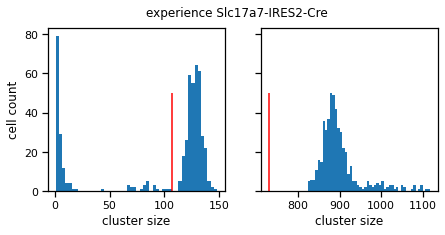

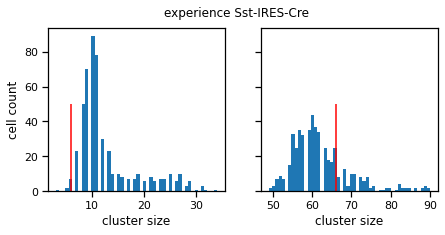

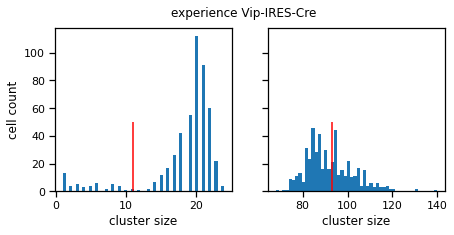

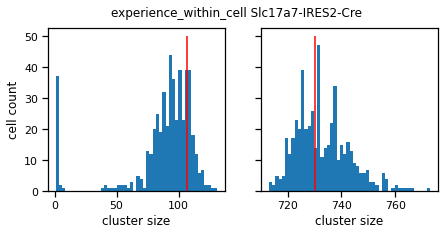

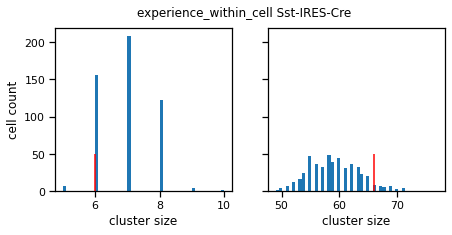

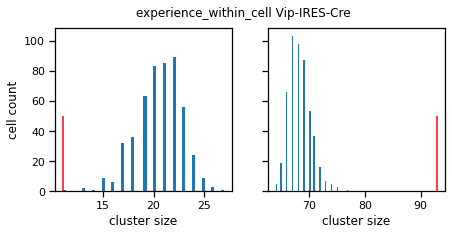

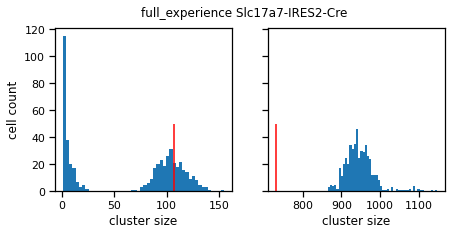

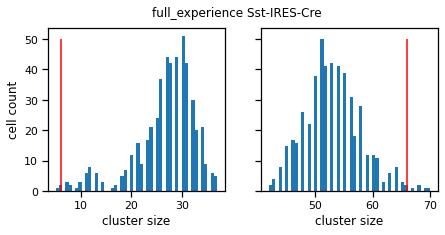

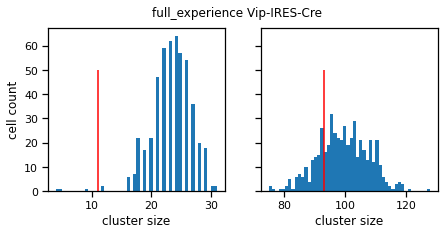

In [27]:
### plot minimum and maximum cluster size in the shuffles
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        min_clusters = []
        max_clusters = []
        for n, n_boot in enumerate(n_boots):
            x = shuffle_type_labels[shuffle_type][cre_line][n][['cluster_id']].value_counts().min()
            min_clusters.append(x)
            
            y = shuffle_type_labels[shuffle_type][cre_line][n][['cluster_id']].value_counts().max()
            max_clusters.append(y)
        fig, ax = plt.subplots(1,2, figsize = (7,3), sharey = 'row')
        ax[0].hist(min_clusters, 50)
        ax[0].vlines(x=original_min_max[cre_line][0], ymin=0, ymax=50, color='r')
        ax[0].set_ylabel('cell count')
        ax[0].set_xlabel('cluster size')
        ax[1].hist(max_clusters, 50)
        ax[1].vlines(x=original_min_max[cre_line][1], ymin=0, ymax=50, color='r')
        ax[1].set_xlabel('cluster size')
        plt.suptitle(shuffle_type +' ' + cre_line)
        utils.save_figure(fig, figsize = (7,3), save_dir=save_dir, folder='',
                          fig_title=f'min_max_cluster_size_{cre_line}_{shuffle_type}')
            

#### compute mean dropout scores for shuffled dfs


In [28]:
shuffle_type_mean_dropout_scores = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n, n_boot in enumerate(n_boots):
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n]
            mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores
        cre_mean_dropout_scores_shuffled[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores[shuffle_type] = cre_mean_dropout_scores_shuffled

In [29]:
### this takes a lot of time so run it at your own risk
### plot clusters
# for shuffle_type in shuffle_types[::-1]:
#     for cre_line in cre_lines[::-1]:
#         for n, n_boot in enumerate(n_boots[:50]):
#             feature_matrix = shuffle_type_df[shuffle_type][cre_line][n]
#             cluster_df = shuffle_type_labels[shuffle_type][cre_line][n].set_index('cell_specimen_id')
#             sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
#             vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
#                                    sort_order=sort_order, rename_clusters=True, save_dir=save_dir, folder='shuffled_plots', 
#                                         suffix='_nb'+str(n_boot)+'_'+shuffle_type)
#             plt.close('all')

### compute SSE

In [30]:
shuffle_type_SSE = {}
for shuffle_type in shuffle_types:
    cre_SSE = {}
    for cre_line in cre_lines:
        nb_sse = {}
        original_df = cre_mean_dropout_scores[cre_line]
        for n, n_boot in enumerate(n_boots):
            shuffled_df = shuffle_type_mean_dropout_scores[shuffle_type][cre_line][n]
            sse = vba_clust.compute_SSE(original_df, shuffled_df)
            nb_sse[n] = sse
        cre_SSE[cre_line] = nb_sse
    shuffle_type_SSE[shuffle_type] = cre_SSE
        



### get cluster mapping

In [31]:
threshold_SSE_mapping = {}
for threshold in thresholds:
    shuffle_type_SSE_mapping = {}
    for shuffle_type in shuffle_types:
        cre_SSE_mapping = {}
        for cre_line in cre_lines:
            nb_sse_mapping = {}
            nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
            cluster_mapping = vba_clust.get_cluster_mapping(nb_matrix, threshold = threshold)
            cre_SSE_mapping[cre_line] = cluster_mapping
        shuffle_type_SSE_mapping[shuffle_type] = cre_SSE_mapping
    threshold_SSE_mapping[threshold] = shuffle_type_SSE_mapping


In [33]:
shuffle_type_dict = {}
shuffle_type_dict['experience']='cell ID'
shuffle_type_dict['experience_within_cell']='labels'
shuffle_type_dict['full_experience']='both'


In [35]:
## use max threshold for this

shuffle_type_SSE_values = {}
for shuffle_type in shuffle_types:
    cre_SSE_values = {}
    for cre_line in cre_lines:
        nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
        cluster_mapping_SSE = vba_clust.get_mapped_SSE_values(nb_matrix, threshold = threshold)
        cre_SSE_values[cre_line] = cluster_mapping_SSE
    shuffle_type_SSE_values[shuffle_type] = cre_SSE_values


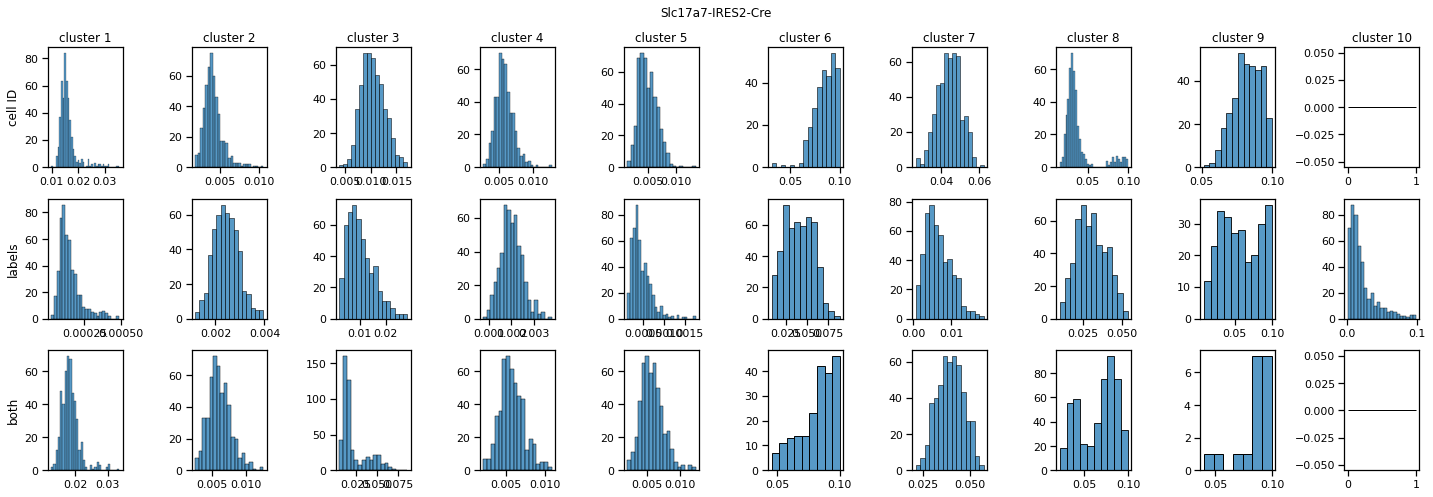

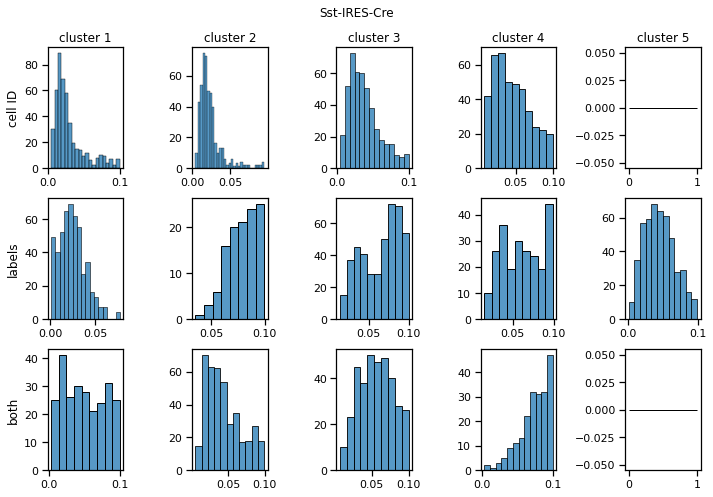

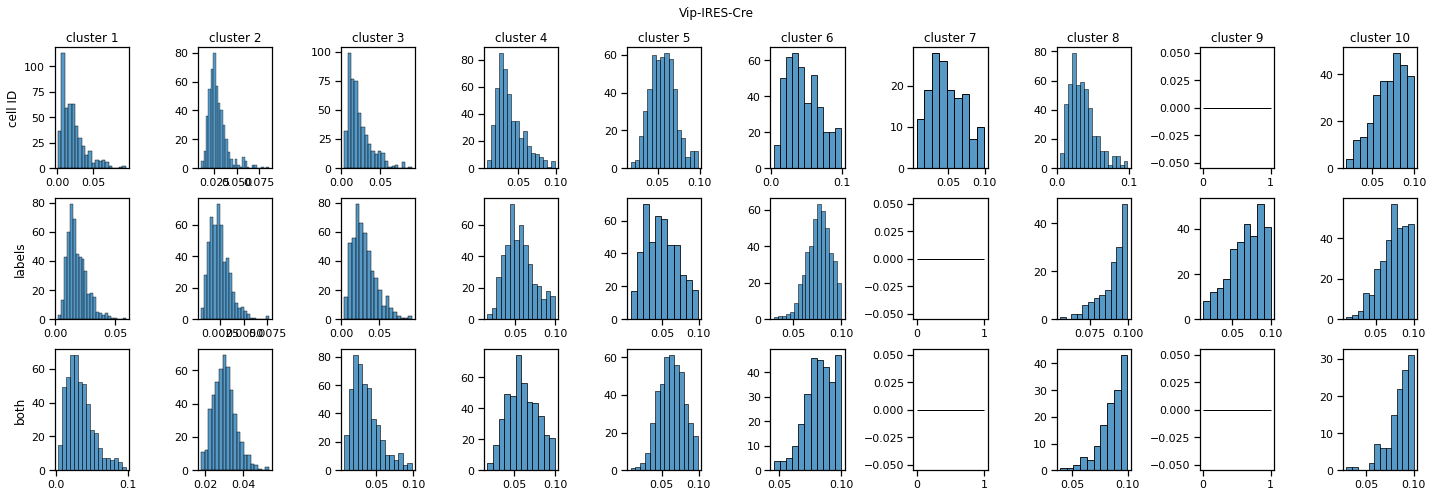

In [37]:
for c,cre_line in enumerate(cre_lines):
    fig = plt.figure(figsize=figsizes[c], )
    ax_i =1
    for s,shuffle_type in enumerate(shuffle_types):
        tmp = shuffle_type_SSE_values[shuffle_type][cre_line]
        cluster_ids = tmp.keys()
        
        for i,cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(3, len(cluster_ids), ax_i, )
            ax = sns.histplot(tmp[cluster_id], ax=ax, )
            if s == 0:
                ax.set_title(f'cluster {cluster_id}')
                
            if cluster_id !=1:
                ax.set_ylabel('')
            else:
                ax.set_ylabel(shuffle_type_dict[shuffle_type])
            ax_i=ax_i+1
            #ax.set_xlim([0, threshold])
    fig.suptitle(cre_line)
        
    plt.tight_layout()
    utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder=f'SSE_hist_by_cluster_{threshold}',
                          fig_title=f'SSE_hist_{cre_line}')
    
# this code blocke plots one row at a time (for easier editing if needed)
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
#         tmp = shuffle_type_SSE_values[shuffle_type][cre_line]
#         cluster_ids = tmp.keys()
#         fig, ax = plt.subplots(1,len(cluster_ids), figsize = (15,3), sharey = "row")
#         for i,cluster_id in enumerate(cluster_ids):
#             ax[i] = sns.histplot(tmp[cluster_id], ax=ax[i], )
#             ax[i].set_title(f'cluster {cluster_id}')
#             #ax[i].set_xlim([0, threshold])
#         plt.suptitle(shuffle_type + ' ' + cre_line)
#         plt.tight_layout()
#         utils.save_figure(fig, figsize = (15,3), save_dir=save_dir, folder='SSE_by_cluster',
#                           fig_title=f'SSE_hist_{cre_line}_{shuffle_type}_{threshold}')

#### Plot SSE 

In [33]:
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
#         for n, n_boot in enumerate(n_boots[:50]):
#             tmp = shuffle_type_SSE[shuffle_type][cre_line][n_boot]
#             labels=np.arange(1,len(tmp)+1)
#             fig, ax = plt.subplots(1,1,figsize = (10,10))
#             ax=sns.heatmap(tmp, annot=True, cmap = 'Greys', 
#                            yticklabels=labels, xticklabels=labels,ax=ax)
#             plt.suptitle(cre_line[:3]+ ' ' + shuffle_type + ' ' + str(n_boot))
#             plt.tight_layout()
#             utils.save_figure(fig, figsize = (10,10), save_dir=save_dir, folder='SSE', 
#                       fig_title=f'SSE_matrix{cre_line[:3]}_nb{n_boot}_{shuffle_type}')
#             plt.close('all')

#### Plot cluster heatmaps with SSE matrix together

In [40]:
#create unstacked mean dropout scores for each cluster for plotting
cre_original_clusters_unstacked = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df, stacked=False)
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    if cre_line == 'Slc17a7-IRES2-Cre':
        mean_dropout_scores[100] = mean_dropout_scores.pop(4)
        mean_dropout_scores[4] = mean_dropout_scores.pop(5)
        mean_dropout_scores[5] = mean_dropout_scores.pop(100)
    cre_original_clusters_unstacked[cre_line] = mean_dropout_scores
            

next cell plots SSE matrix with shuffled and original clusters

In [39]:
# import matplotlib.gridspec as gr
# figsizes =  [(20,15), (15, 15), (20,15)]
# for shuffle_type in shuffle_types:
#     for n,n_boot in enumerate(n_boots[50:100]):
#         for c,cre_line in enumerate(cre_lines):
#             shuffled = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n]
#             original = cre_original_clusters_unstacked[cre_line]
#             cluster_ids = shuffled.keys()
#             n_clusters = len(cluster_ids)
            
            
#             gs = gr.GridSpec(n_clusters+1, n_clusters+1, width_ratios=[2]*(n_clusters+1), height_ratios=[2]*(n_clusters+1))
#             fig = plt.figure(figsize = figsizes[c])
            
#             # plot shuffled
#             for i, cluster_id in enumerate(cluster_ids):
#                 ax = fig.add_subplot(gs[0, i])
#                 ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
#                     xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
#                     cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
#                 if i!=0:
#                     ax.set_yticklabels('')
#                 ax.set_xticklabels('')
#                 ax.set_xlabel('')
                
#             # plot original clusters
#             for i, cluster_id in enumerate(cluster_ids):
#                 ax = fig.add_subplot(gs[cluster_id, n_clusters])
#                 ax = sns.heatmap(original[cluster_id].loc[vba_clust.get_features_for_clustering()],
#                     xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
#                     cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
#                 ax.set_yticklabels('')
#                 ax.set_xlabel('')
#                 if cluster_id !=n_clusters:
#                     ax.set_xticklabels('')
                
                
#              # Plot SSE
#             tmp = shuffle_type_SSE[shuffle_type][cre_line][n]
#             labels=np.arange(1,len(tmp)+1)
#             ax = fig.add_subplot(gs[1:,:n_clusters])
#             ax=sns.heatmap(tmp, annot=True, cmap = 'Greys', 
#                                 yticklabels=labels, xticklabels=labels,cbar=False,ax=ax)
         
#             plt.tight_layout()
#             utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder=os.path.join(shuffle_type, cre_line[:3], 'SSE_plots'),
#                           fig_title=f'SSE_hist_{shuffle_type}_{cre_line[:3]}_nb{n_boot}', formats=['.png'])
#             plt.close('all')


#### plotting aligned clusters into one folder
This will make it easier to scroll through plots and to make sure that all matched clusters are well matched


In [41]:
#create unstacked mean dropout scores for ach cluster for plotting
shuffle_type_mean_dropout_scores_unstacked = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled_unstacked = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n,n_boot in enumerate(n_boots):
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n]
            #cluster_df = cluster_df.rename(mapper={'labels':'cluster_id'}, axis=1)
            mean_dropout_scores_unstacked = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df, stacked=False)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores_unstacked
        cre_mean_dropout_scores_shuffled_unstacked[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores_unstacked[shuffle_type] = cre_mean_dropout_scores_shuffled_unstacked

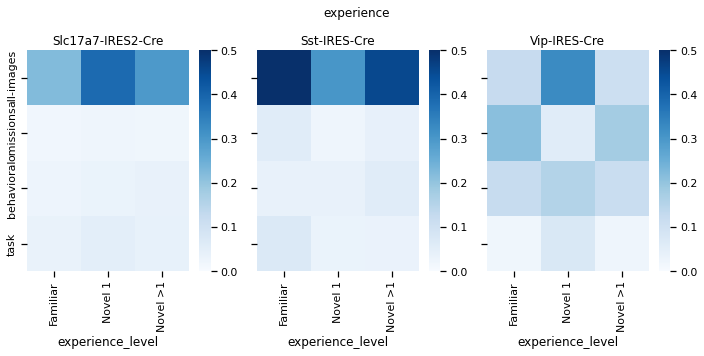

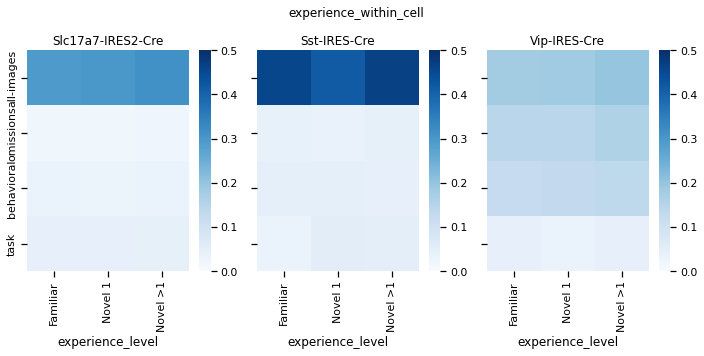

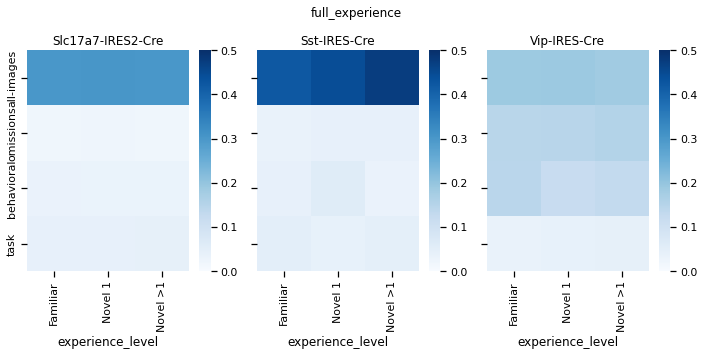

In [42]:
### pot mean of shuffled dropout scores regardless of clusters.
for shuffle_type in shuffle_types:
    fig, ax = plt.subplots(1,3, figsize = (10,5), sharey='row')
    for c, cre_line in enumerate(cre_lines):
        for n, n_boot in enumerate(n_boots):
            if n ==0:
                dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            else:
                dropout_scores.append(shuffle_type_df[shuffle_type][cre_line][n], ignore_index=True)
        mean_df = dropout_scores.mean().unstack()
        features = vba_clust.get_features_for_clustering()
        mean_df = mean_df.loc[features]
        ax[c] = sns.heatmap(mean_df, cmap='Blues', ax=ax[c], vmin=0, vmax=0.5)
        ax[c].set_title(cre_line)
    plt.suptitle(shuffle_type)
    plt.tight_layout()
    utils.save_figure(fig, figsize = (10,5), save_dir=save_dir, folder='', fig_title=f'mean_dropout_scores_{shuffle_type}_{threshold}')

In [43]:

# # This takes forever, so commenting it out unless it's needed
# # plot
# vmin = 0
# cmap = 'Blues'
# # loop through the thresholds first
# for threshold in thresholds:
#     shuffle_type_SSE_mapping = threshold_SSE_mapping[threshold]
#     #shuffle_types = shuffle_type_SSE_mapping.keys()
    
#     # loop through shuffle types
#     for shuffle_type in shuffle_types[::-1]:
#         #cre_lines = shuffle_type_SSE_mapping[shuffle_type].keys()
        
#         # loop through cre lines
#         for cre_line in cre_lines[::-1]:
#             # n_boots = shuffle_type_SSE_mapping[shuffle_type][cre_line].keys()
#             # n_boots is already specified. You cant select a handful when using dictionary keys so commenting it out
            
#             # plot only a few examples for speed
#             for n_boot in n_boots[100:130]:

#                 cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].keys()
#                 for cluster_id in cluster_ids:
#                     matched_cluster_id = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot][cluster_id]
#                     if matched_cluster_id !=-1:
#                         dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][matched_cluster_id]

#                         # plot cluster
#                         fig, ax = plt.subplots()    
#                         sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
#                         ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

#                         # save
#                         this_folder = os.path.join(shuffle_type+str(threshold), cre_line[:3], f'cluster_{cluster_id}')
#                         this_dir = os.path.join(save_dir, this_folder)
#                         if not os.path.exists(this_dir):
#                             os.makedirs(this_dir)    
#                         plt.tight_layout()
#                         figname = 'nb_{}.png'.format(n_boot)
#                         fig.savefig(os.path.join(this_dir, figname))

#                         plt.close('all')

#                 # plot all unmatched clusters into one folder
#                 # all matched cluster ids
#                 matched_cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].values()
#                 for cluster_id in cluster_ids:
#                     # if it is not in matched cluster ids, plot and save into unmatched folder
#                     if cluster_id not in matched_cluster_ids:
#                         dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][cluster_id]
#                         # plot cluster
#                         fig, ax = plt.subplots()    
#                         sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
#                         ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

#                         # save
#                         this_folder = os.path.join(shuffle_type+str(threshold), cre_line[:3], 'unmatched')
#                         this_dir = os.path.join(save_dir, this_folder)
#                         if not os.path.exists(this_dir):
#                             os.makedirs(this_dir)    
#                         plt.tight_layout()
#                         figname = 'nb_{}_cluster_id_{}.png'.format(n_boot, cluster_id)
#                         fig.savefig(os.path.join(this_dir, figname))

#                         plt.close('all')


In [53]:
threshold_probabilities = {}
for threshold in thresholds:
    shuffle_type_probabilities = {}
    shuffle_type_SSE_mapping = threshold_SSE_mapping[threshold]
    for shuffle_type in shuffle_types:
        cre_cluster_probabilities = {}
        for cre_line in cre_lines:
            SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
            cre_cluster_probabilities[cre_line] = vba_clust.compute_probabilities(SSE_mapping)
        shuffle_type_probabilities[shuffle_type] = cre_cluster_probabilities
    threshold_probabilities[threshold] = shuffle_type_probabilities

In [54]:
for threshold in thresholds:
    for shuffle_type in shuffle_types:
        filename = 'cre_cluster_probabilities_{}_{}.pkl'.format(shuffle_type, str(threshold))
        vba_clust.save_clustering_results(threshold_probabilities [threshold][shuffle_type], os.path.join(save_dir, 'files', filename))

In [55]:
threshold_cluster_sizes = {}
for threshold in thresholds:
    shuffle_type_cluster_sizes = {}
    shuffle_type_SSE_mapping = threshold_SSE_mapping[threshold]
    for shuffle_type in shuffle_types:
        cre_cluster_sizes = {}
        for cre_line in cre_lines:
            SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
            cluster_df_shuffled = shuffle_type_labels[shuffle_type][cre_line]
            all_cluster_sizes = vba_clust.get_cluster_size_variance(SSE_mapping, cluster_df_shuffled)
            cre_cluster_sizes[cre_line] = all_cluster_sizes 
        shuffle_type_cluster_sizes[shuffle_type] = cre_cluster_sizes
    threshold_cluster_sizes[threshold] = shuffle_type_cluster_sizes

In [56]:
for threshold in thresholds:
    for shuffle_type in shuffle_types:
        filename = 'cre_cluster_sizes_{}_{}.pkl'.format(shuffle_type, threshold)
        vba_clust.save_clustering_results(threshold_cluster_sizes[threshold][shuffle_type], os.path.join(save_dir, 'files', filename))

### Plot proportions for matched clusters

In [57]:
cre_original_cluster_sizes = {}
for cre_line in cre_lines:
    tmp = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    cre_original_cluster_sizes[cre_line] = tmp.value_counts('cluster_id')
    

In [58]:
# shuffle_type_cluster_sizes = {}
# for shuffle_type in shuffle_types:
#     filename = 'cre_cluster_sizes_{}_220802.pkl'.format(shuffle_type)
#     full_path = os.path.join(save_dir,filename)
#     with open(full_path, 'rb') as f:
#         shuffle_type_cluster_sizes[shuffle_type] = pkl.load(f)
#         f.close()


In [59]:
# shuffle_type_probabilities = {}
# for shuffle_type in shuffle_types:
#     filename = 'cre_cluster_probabilities_{}_220802.pkl'.format(shuffle_type)
#     full_path = os.path.join(save_dir, filename)
#     with open(full_path, 'rb') as f:
#         shuffle_type_probabilities[shuffle_type] = pkl.load(f)
#         f.close()

In [60]:
probability_dict = {}
for threshold in thresholds:
    shuffle_type_probabilities = threshold_probabilities[threshold]
    probability_dict[threshold]= vba_clust.get_cluster_probability_df(shuffle_type_probabilities)

In [61]:
cluster_size_difference_dict = {}
for threshold in thresholds:
    shuffle_type_cluster_sizes = threshold_cluster_sizes[threshold]
    cluster_size_difference_dict[threshold] = vba_clust.get_cluster_size_differece_df(cre_original_cluster_sizes, shuffle_type_cluster_sizes)

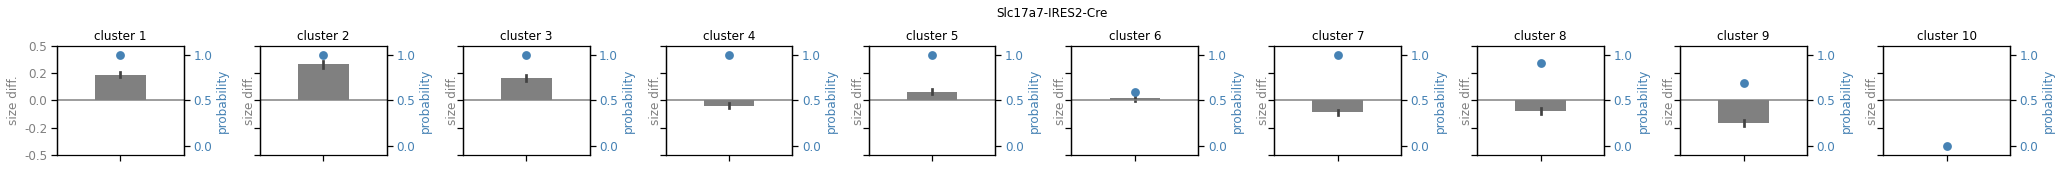

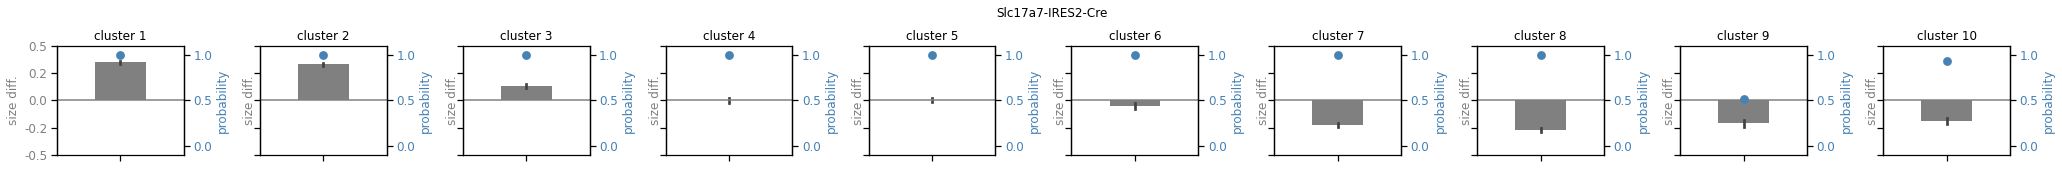

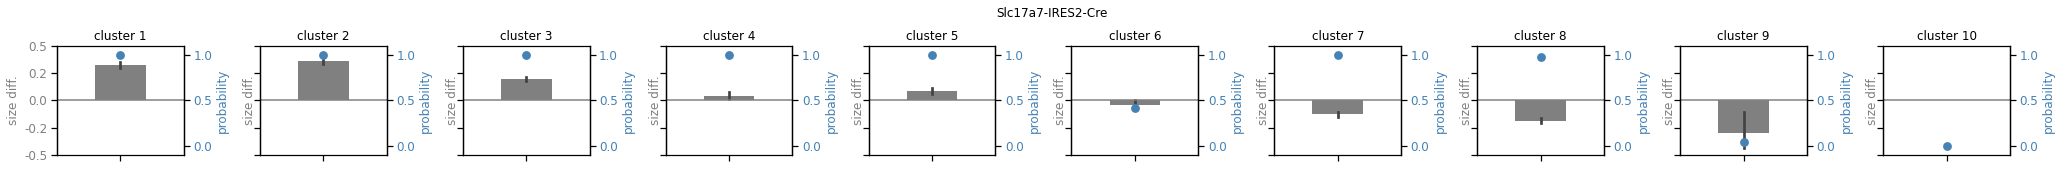

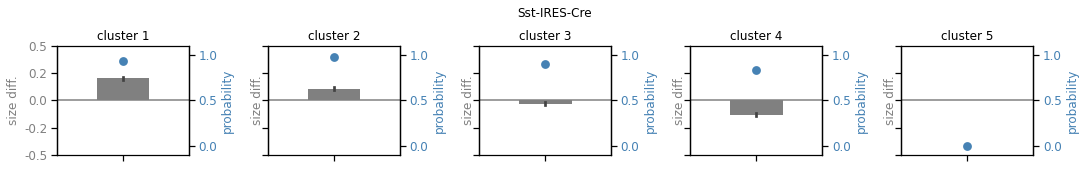

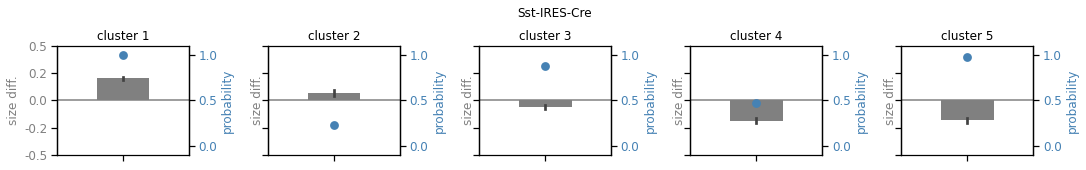

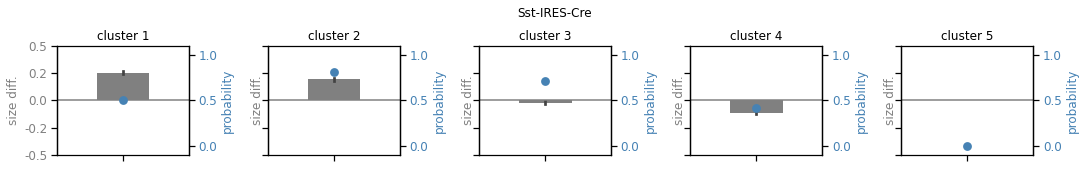

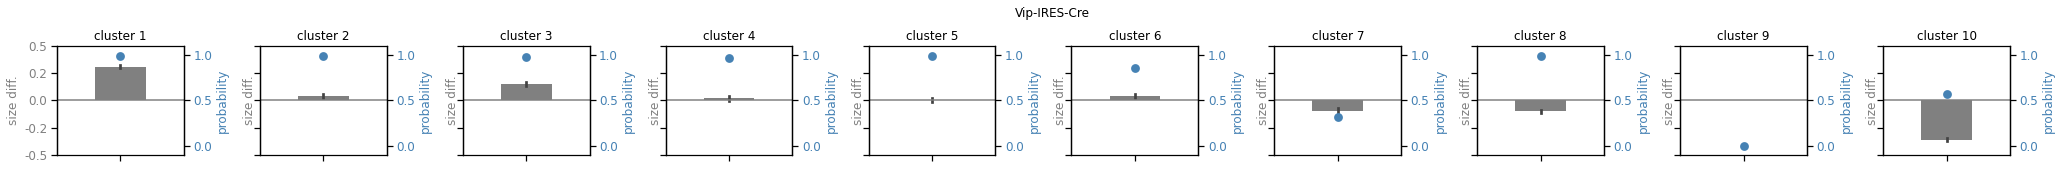

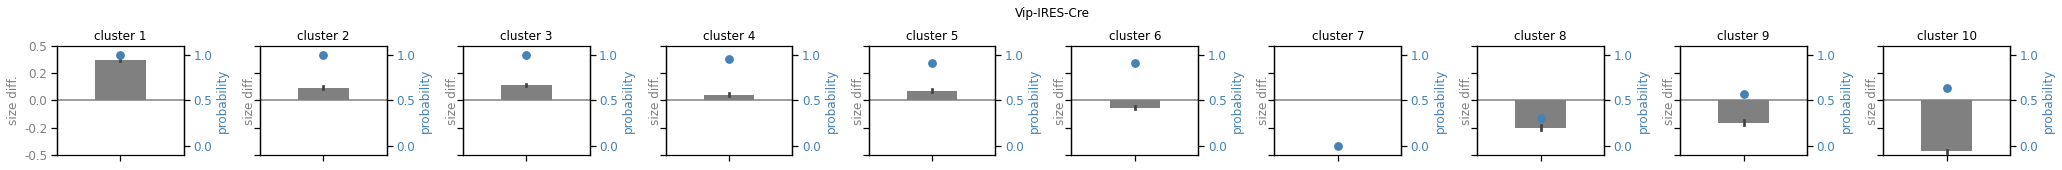

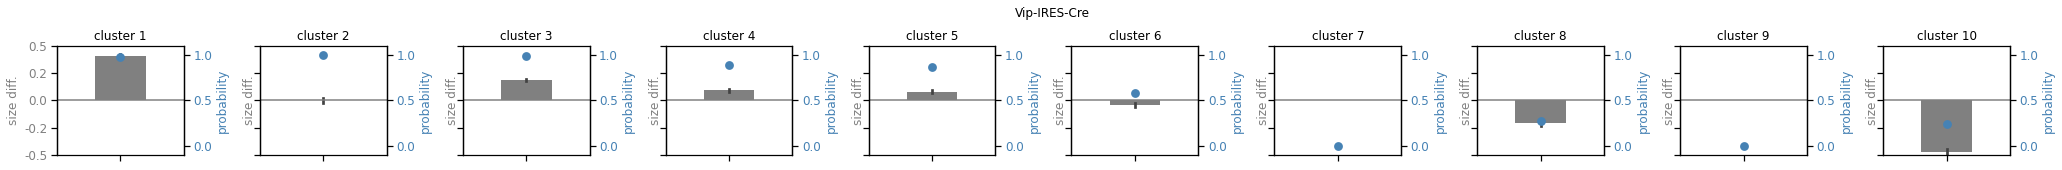

In [63]:
%%capture --no-display 
for threshold in thresholds:
    for cre_line in cre_lines:
        for s, shuffle_type in enumerate(shuffle_types):
            vba_clust.plot_cluster_size_and_probability(cluster_size_difference_dict[threshold], 
                                                        probability_dict[threshold], 
                                                        cre_line=cre_line, 
                                                        shuffle_type=shuffle_type,
                                                       save_dir=save_dir,
                                                       folder = f'{shuffle_type}{threshold}')


#### plot mean heatmap of matched clusters

to do:
    fix this plotting function

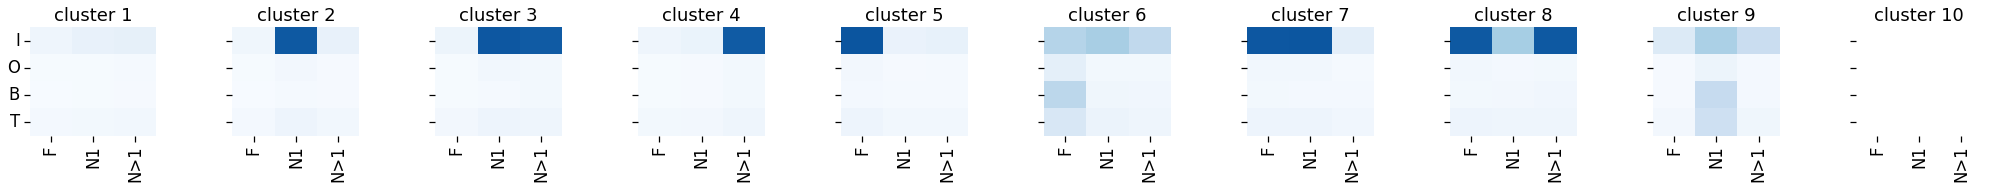

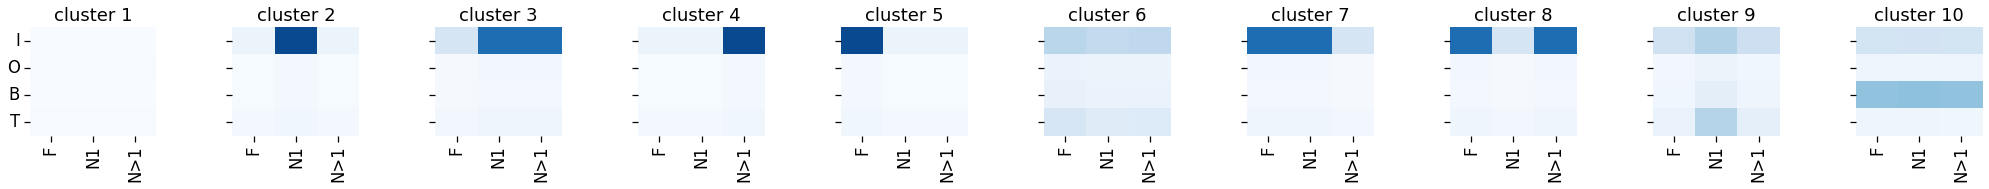

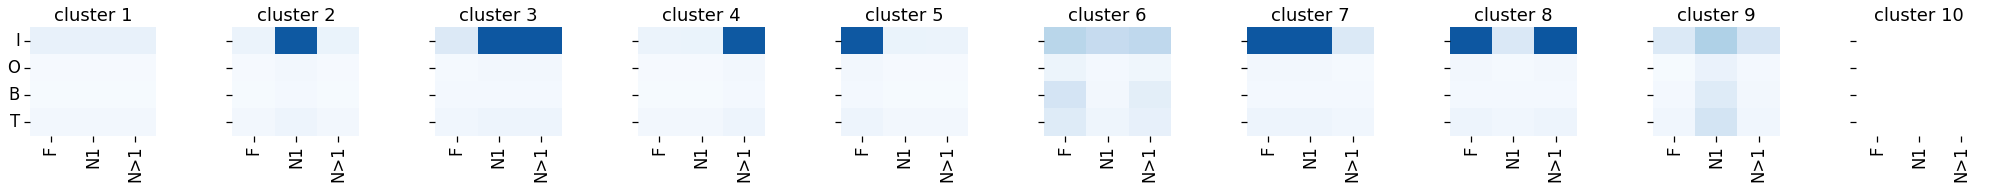

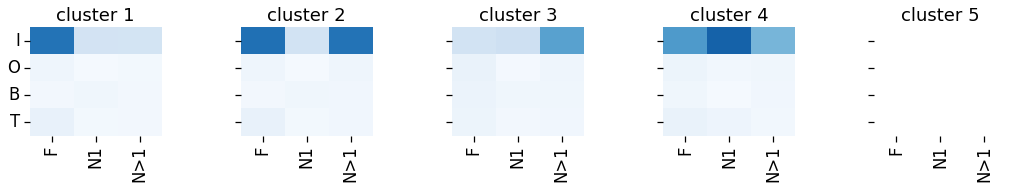

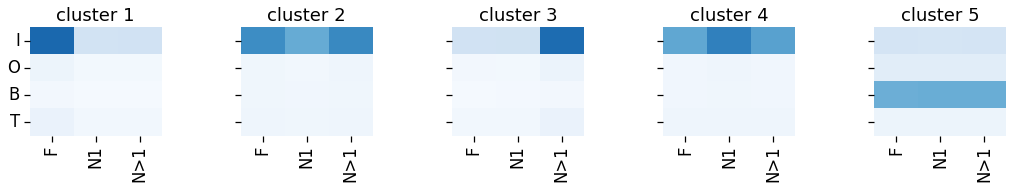

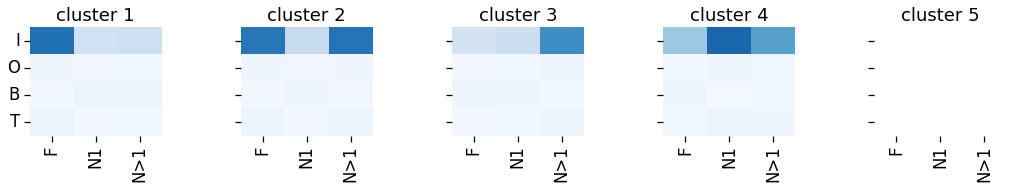

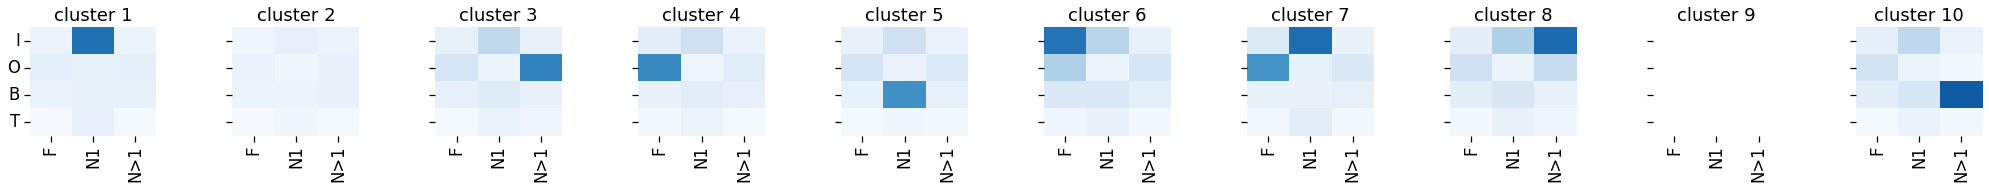

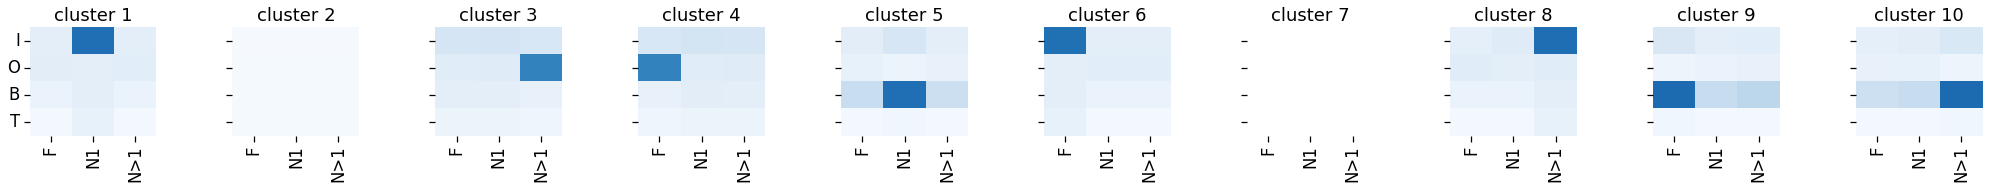

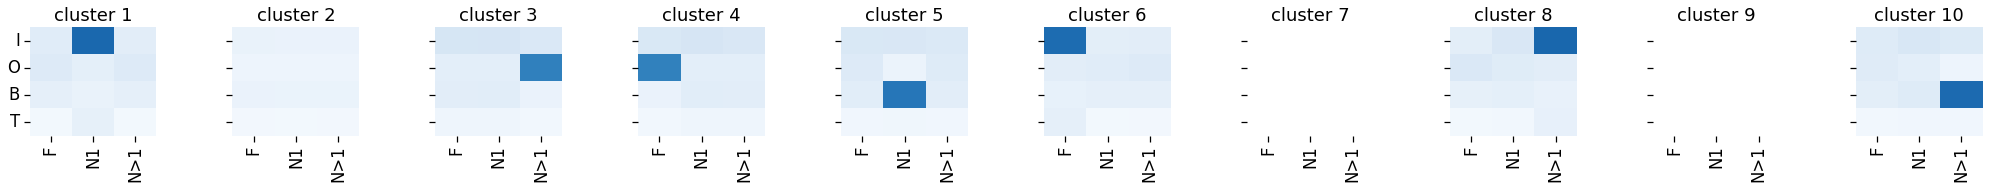

In [64]:
for threshold in thresholds:
    for cre_line in cre_lines:
        for shuffle_type in shuffle_types:
            vba_clust.plot_matched_clusters_heatmap(SSE_mapping = threshold_SSE_mapping[threshold], 
                                                    mean_dropout_scores_unstacked= shuffle_type_mean_dropout_scores_unstacked ,
                                                    cre_line=cre_line, metric='mean',
                                                    shuffle_type=shuffle_type, save_dir=save_dir, folder=f'{shuffle_type}{threshold}')



In [65]:
threshold_corr_dict = {}
for threshold in thresholds:
    shuffle_corr_dict = {}
    for shuffle_type in shuffle_types:
        corr_dict = {}
        for cre_line in cre_lines:
            corr_dict[cre_line]= vba_clust.get_corr_for_matched_clusters_dict(shuffle_type_SSE_mapping, 
                                                           shuffle_type_mean_dropout_scores,
                                                            shuffle_type = shuffle_type,
                                                           cre_line = cre_line)
        shuffle_corr_dict[shuffle_type] = corr_dict
    threshold_corr_dict[threshold] = shuffle_corr_dict

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


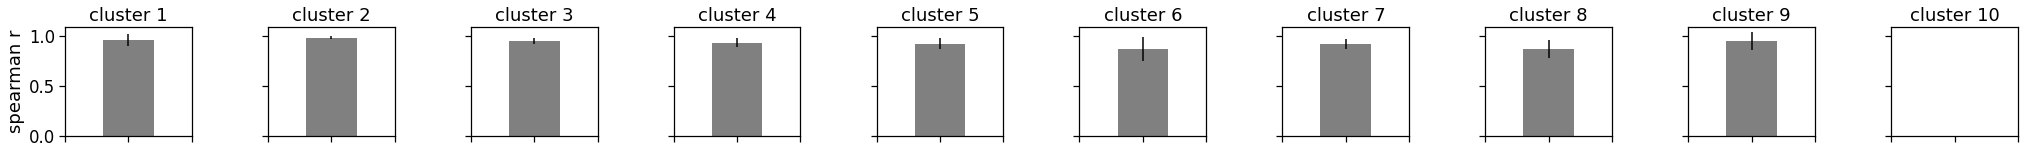

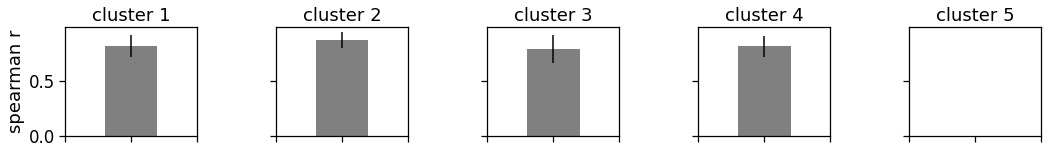

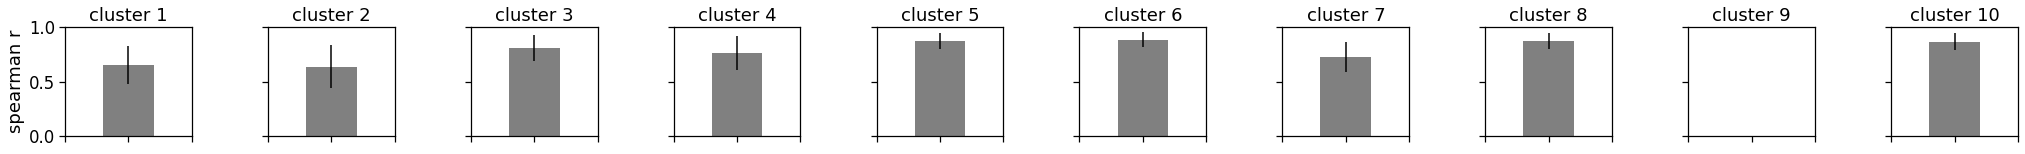

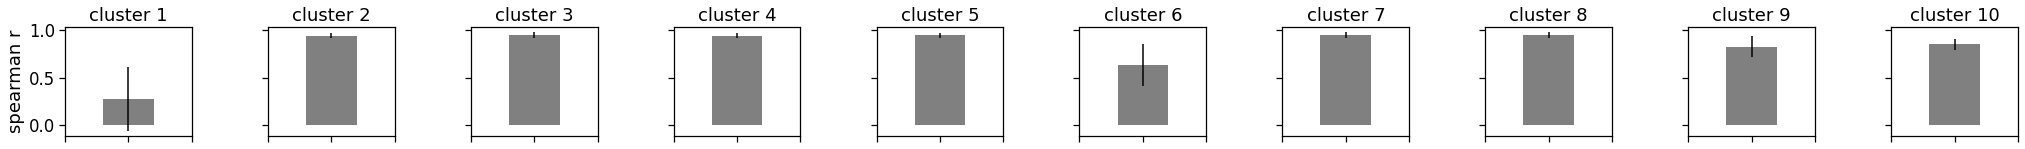

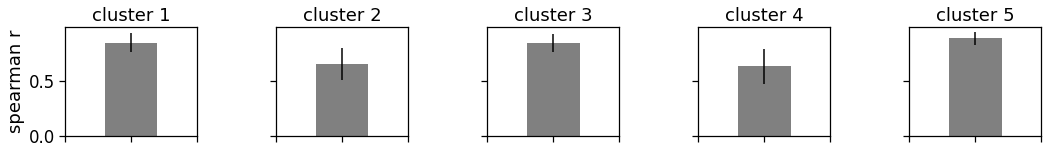

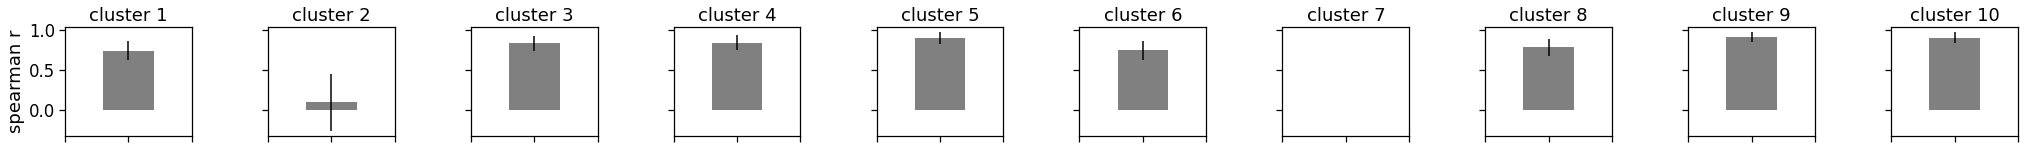

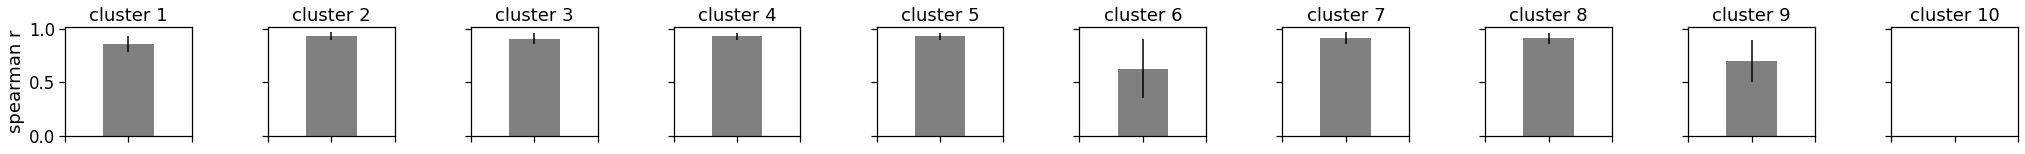

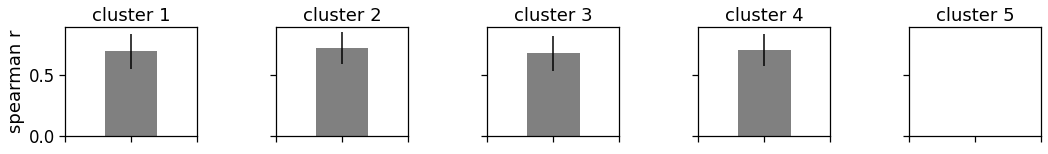

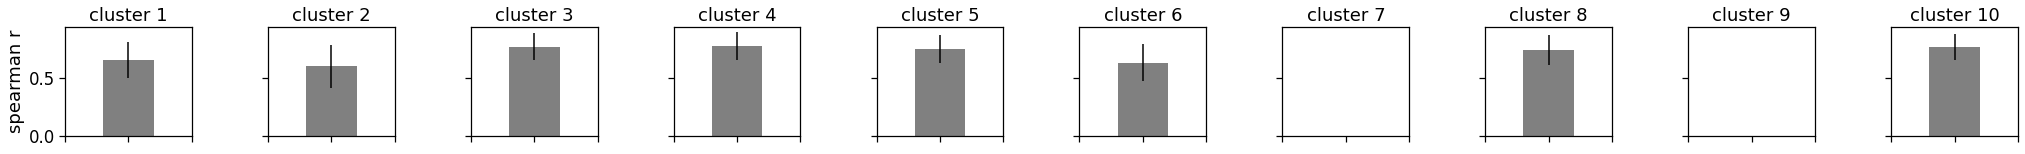

In [66]:
for threshold in thresholds:
    for shuffle_type in shuffle_types:
        for cre_line in cre_lines:
            corr_dict = threshold_corr_dict[threshold][shuffle_type][cre_line]
            n_clusters = len(corr_dict.keys())
            figsize=(3.5*n_clusters,2)
            fig, ax = plt.subplots(1,n_clusters, figsize = figsize, sharey='row')
            for i, cluster_id in  enumerate(corr_dict.keys()):
                ax[i].bar(cluster_id, corr_dict[cluster_id][0], color='Grey')
                ax[i].errorbar(cluster_id, corr_dict[cluster_id][0], corr_dict[cluster_id][1], 
                            color='k')
                ax[i].set_xticklabels([cluster_id])
                if i ==0 :
                    ax[i].set_ylabel('spearman r')
                ax[i].set_xlabel('')
                ax[i].set_title(f'cluster {cluster_id}')
                ax[i].set_xticklabels('')
                ax[i].set_xlim([cluster_id-1, cluster_id+1])

            #plt.suptitle(cre_line + ' ' + shuffle_type)
            fig.subplots_adjust(hspace=1.2, wspace=0.6)
            utils.save_figure(fig, figsize, save_dir, f'{shuffle_type}{threshold}',
                          f'{shuffle_type}_spearman_within_matched_' + cre_line[:3]  )


### try to match SSE values for mean plots

In [ ]:

for n in range(5):
    SSE_values = shuffle_type_SSE[shuffle_type][cre_line][n]
    SSE_map =  SSE_mapping[shuffle_type][cre_line][n]
    
    # convert to df for easier operation
    SSE_values_df = pd.DataFrame(SSE_values, 
                             columns = [np.arange(1,len(SSE_values)+1)],
                             index = [np.arange(1,len(SSE_values)+1)])
    SSE_map_df = pd.DataFrame(data=SSE_map, index = [0])
    
    
    for cluster_id in SSE_map.keys():
        
    
    
    # use only values of shuffled_clusters that were matched to original clusters
    matched_index = SSE_map_df.values[0]!=-1
    matched_SSE = SSE_values_df.iloc[matched_index]
    
    
    

In [ ]:
def get_mean_SSE_per_cluster(SSE_mapping)
    
    shuffle_type_SSE[shuffle_type][cre_line][n]


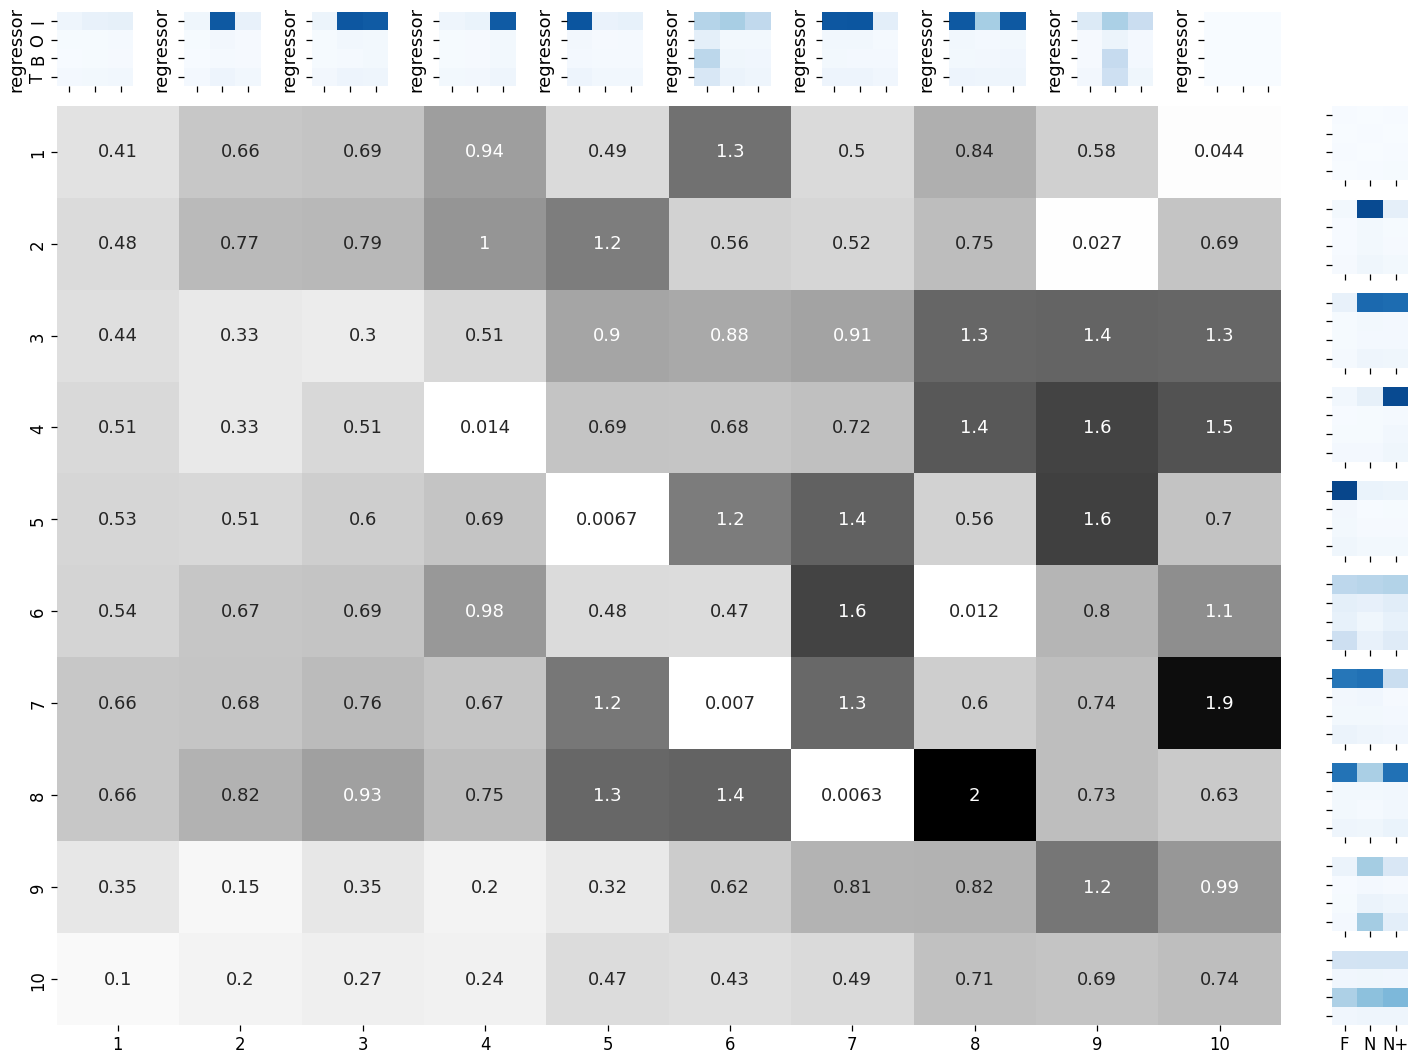

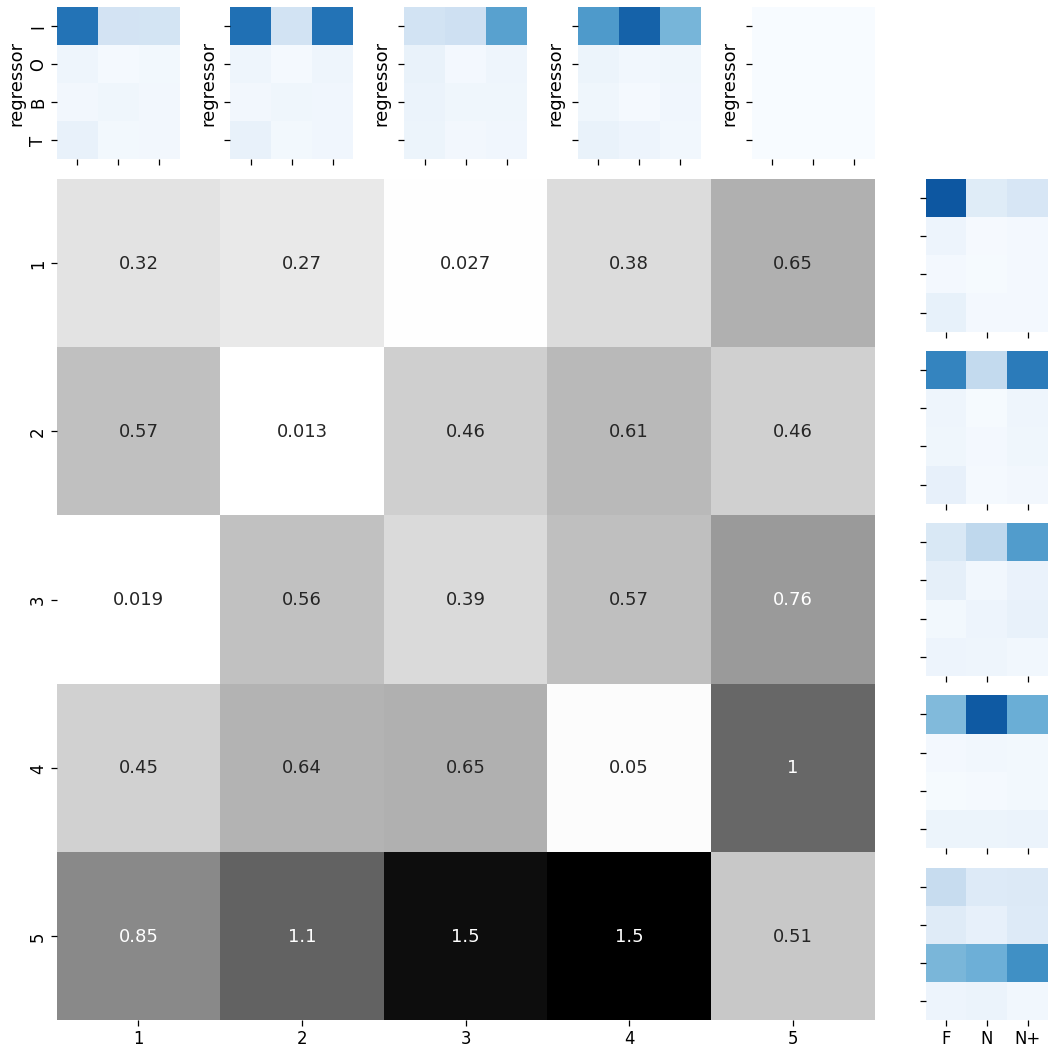

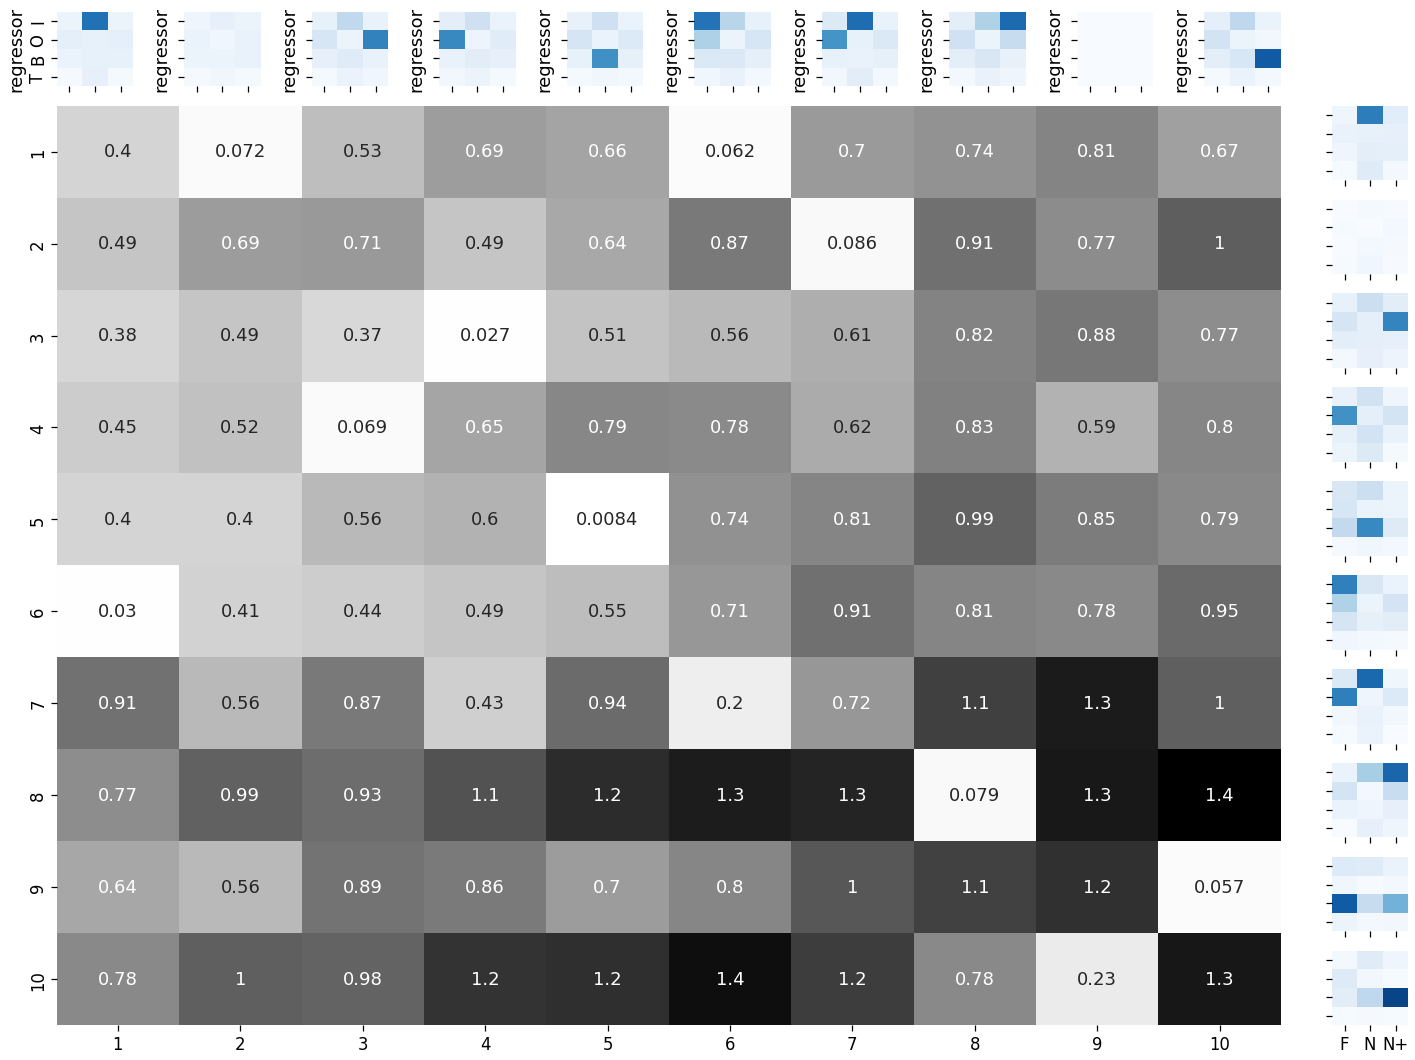

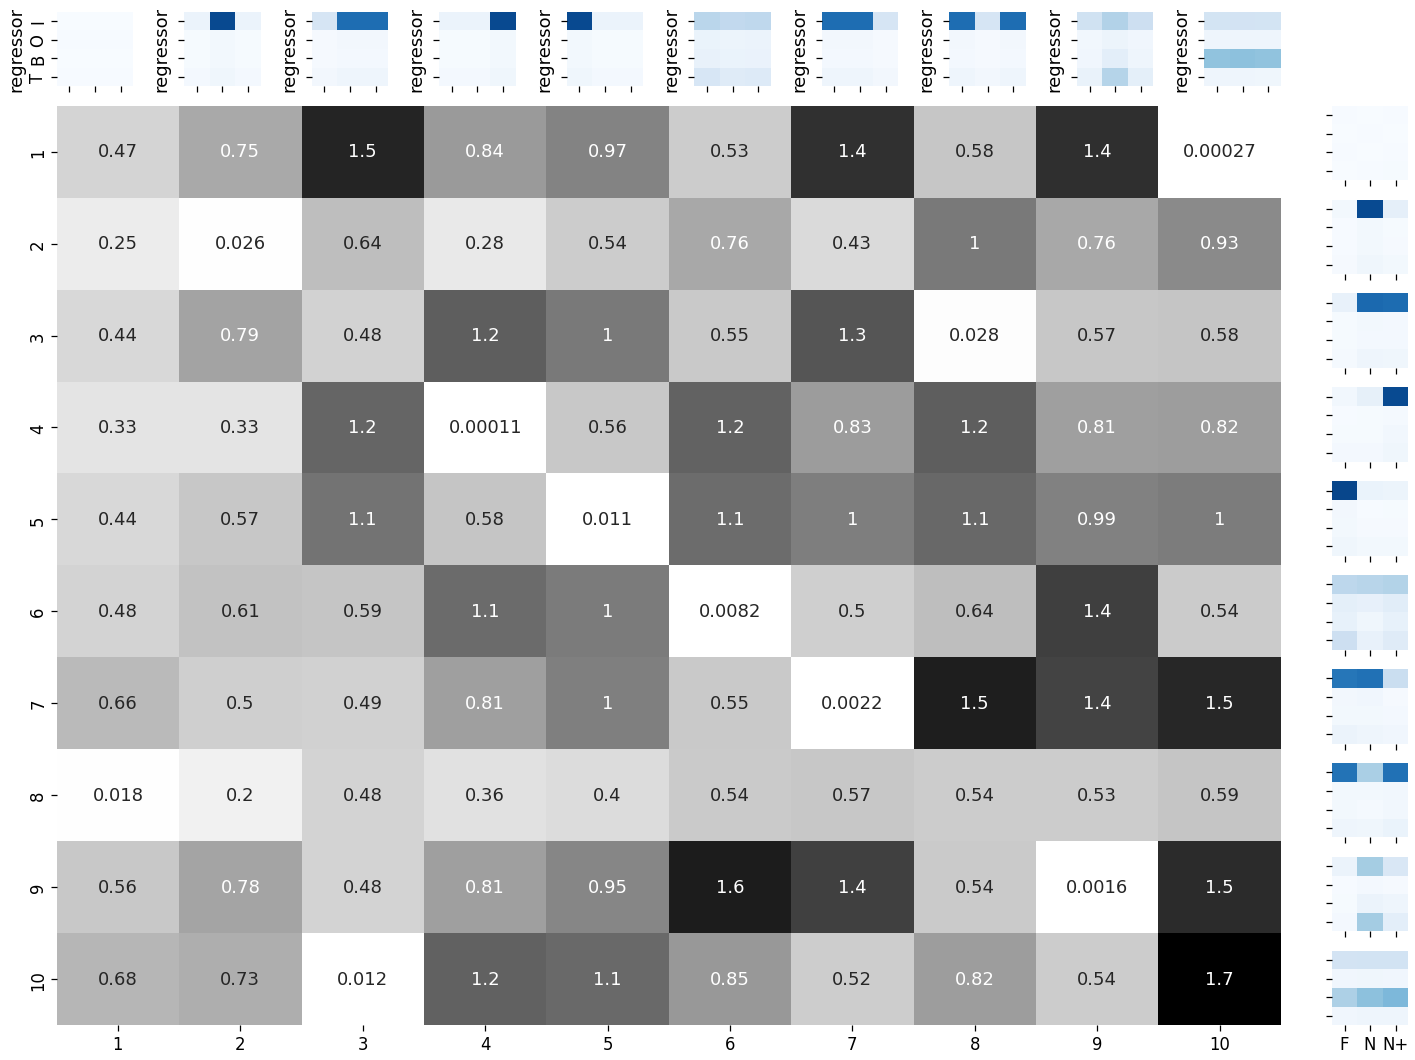

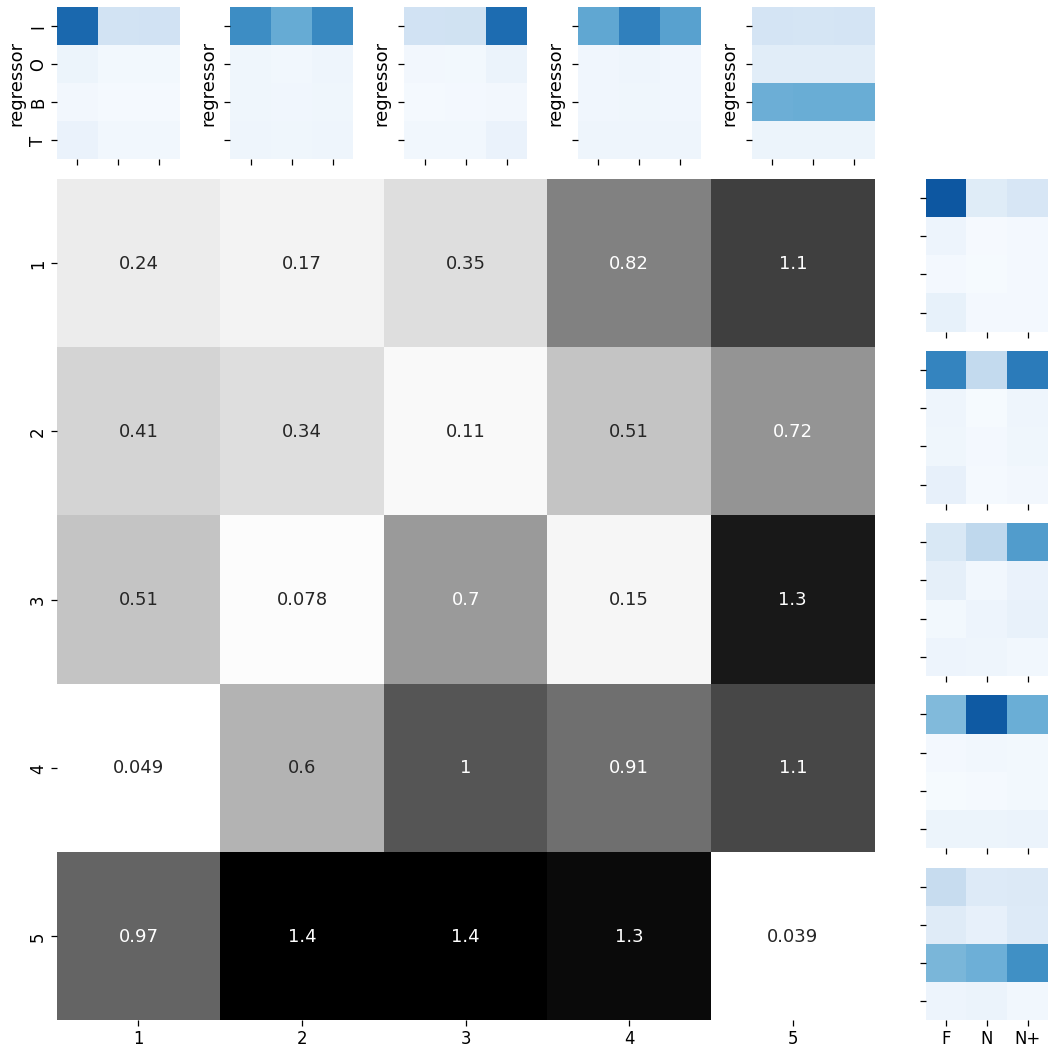

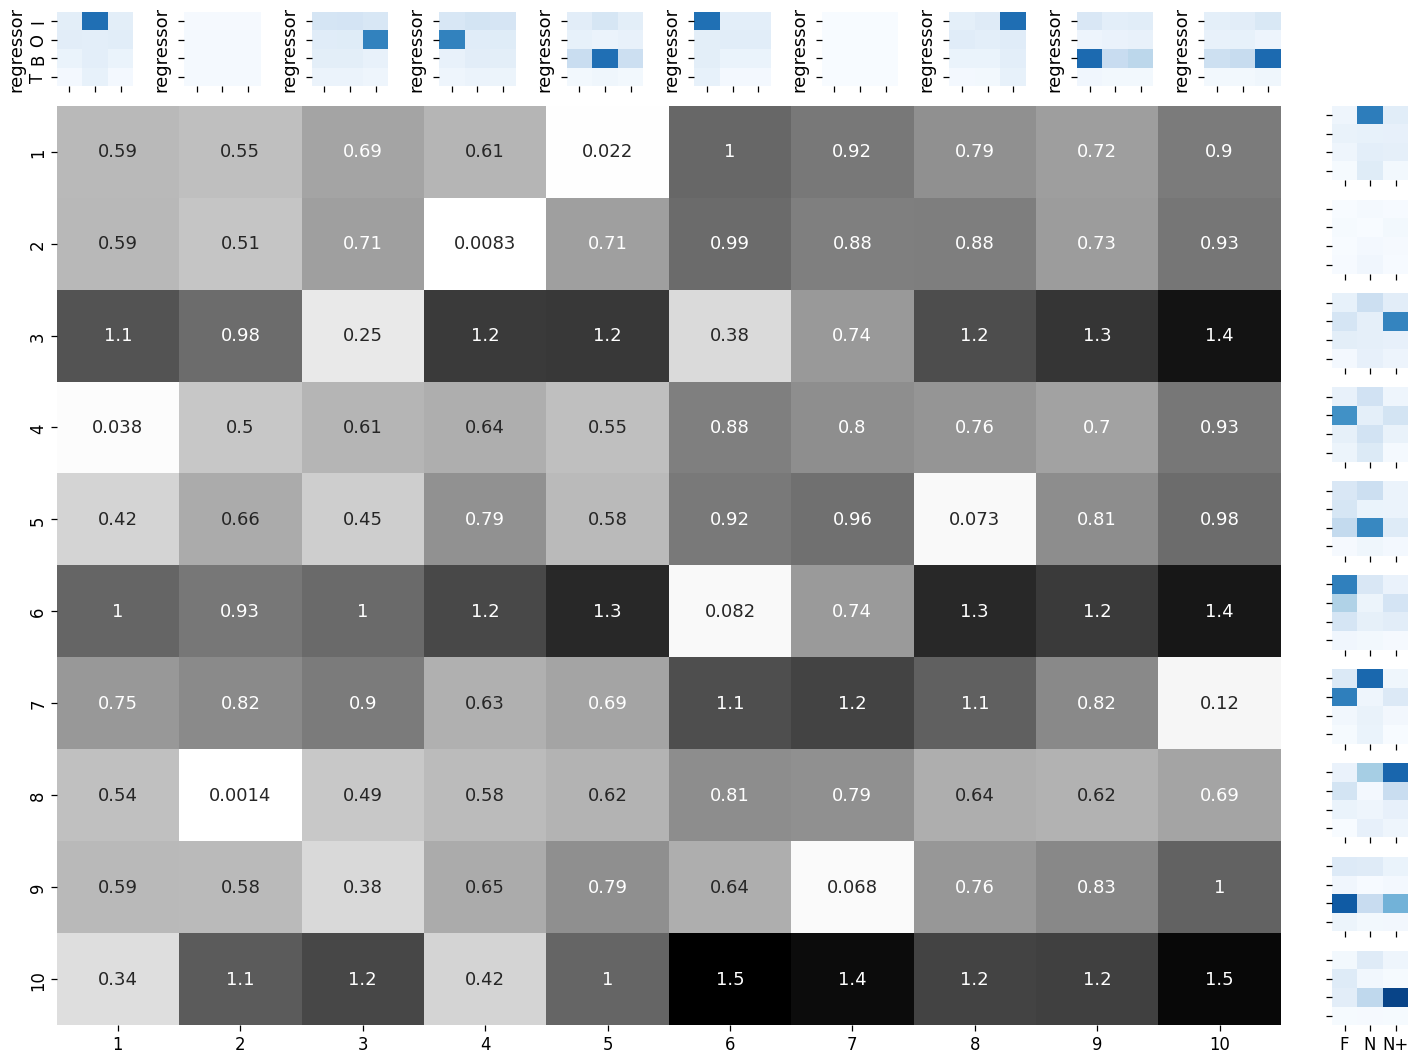

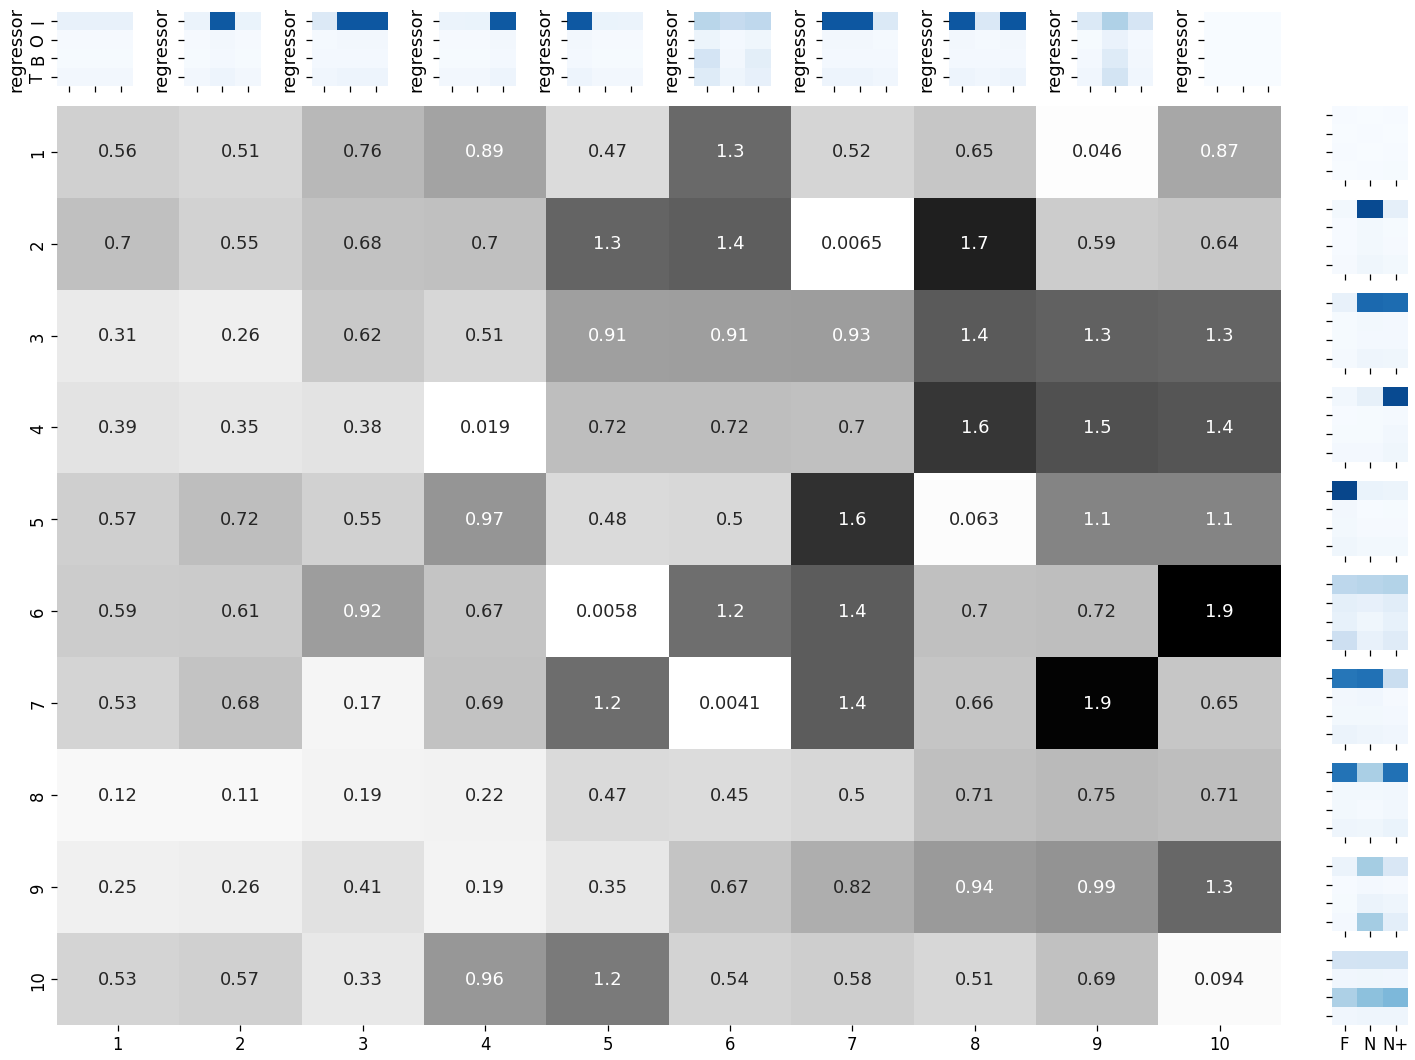

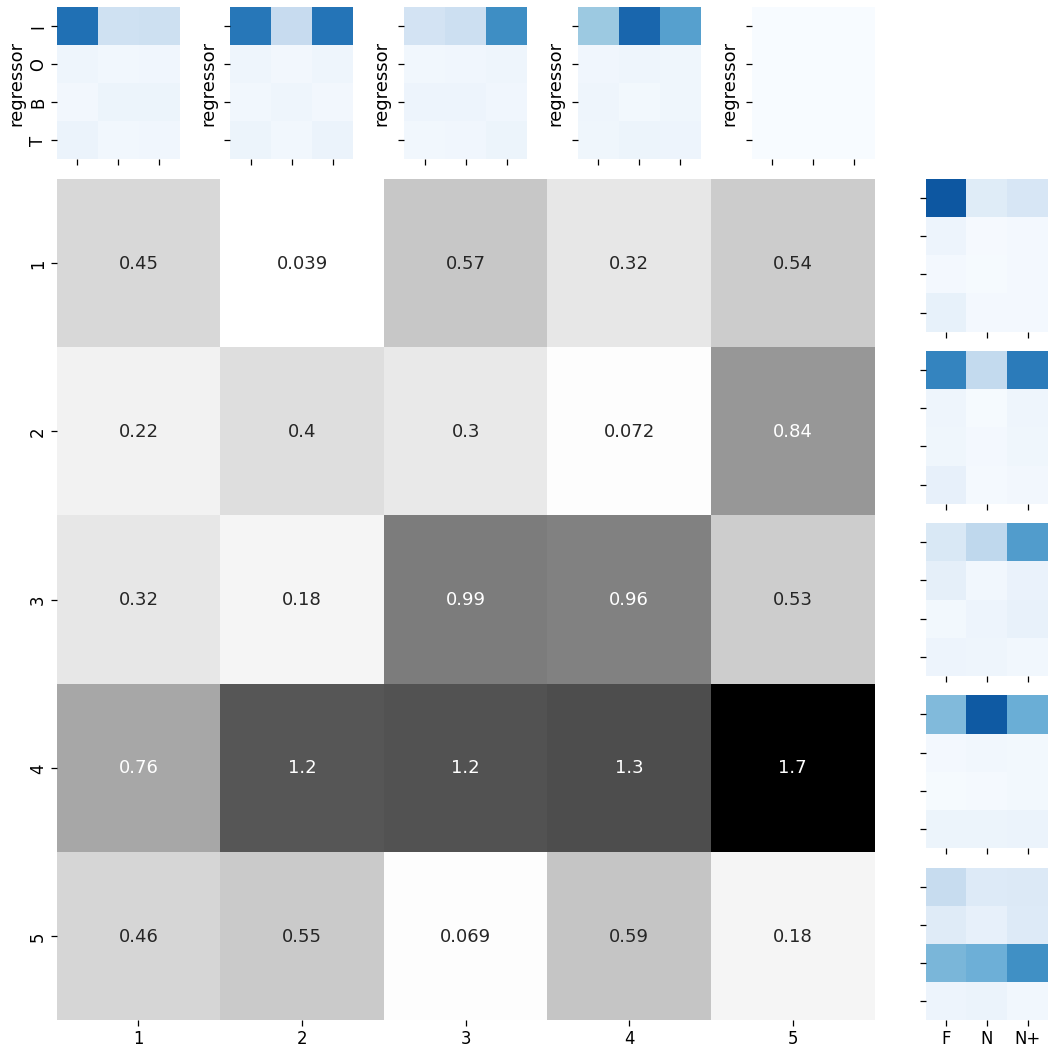

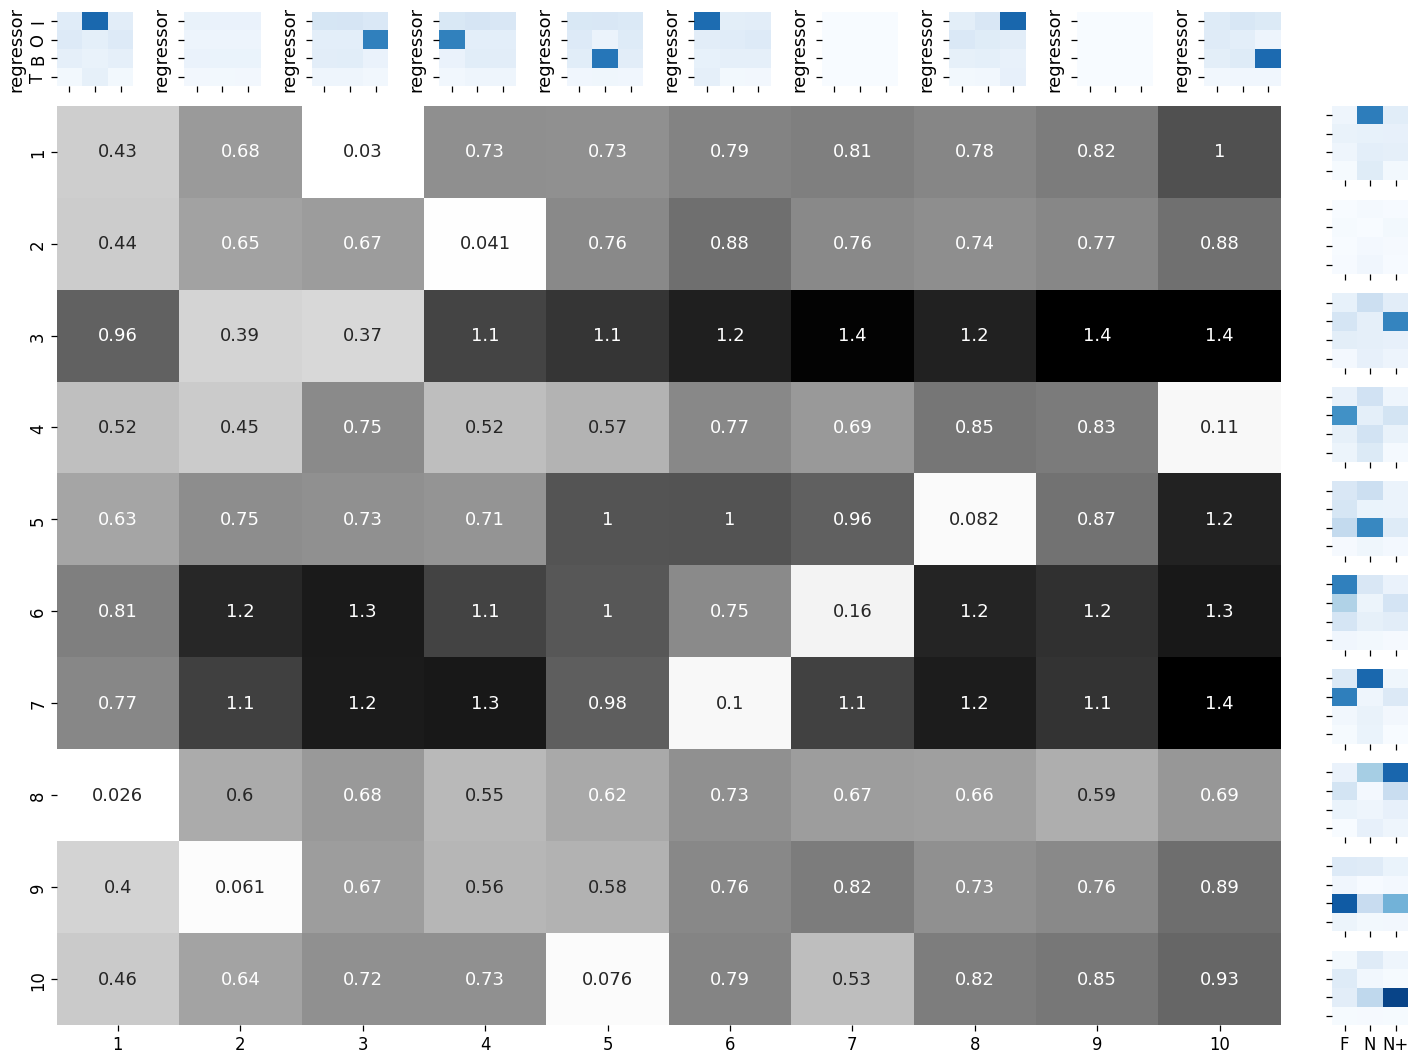

In [88]:
### make one mean figure with diagonal SSE matching plot

import matplotlib.gridspec as gr
figsizes =  [(20,15), (15, 15), (20,15)]
for shuffle_type in shuffle_types:
    for c,cre_line in enumerate(cre_lines):
        SSE_mapping = threshold_SSE_mapping[threshold]
        
        shuffled = vba_clust.get_matched_clusters_means_dict(SSE_mapping, shuffle_type_mean_dropout_scores_unstacked, metric='mean', shuffle_type=shuffle_type,
                                    cre_line=cre_line)      
        original = cre_original_clusters_unstacked[cre_line]
        cluster_ids = shuffled.keys()
        n_clusters = len(cluster_ids)
            
            
        gs = gr.GridSpec(n_clusters+1, n_clusters+1, width_ratios=[2]*(n_clusters+1), height_ratios=[2]*(n_clusters+1))
        fig = plt.figure(figsize = figsizes[c])
            
        # plot shuffled
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[0, i])
            ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            if i!=0:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_xlabel('')

        # plot original clusters
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[cluster_id, n_clusters])
            ax = sns.heatmap(original[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            ax.set_yticklabels('')
            ax.set_xlabel('')
            if cluster_id !=n_clusters:
                ax.set_xticklabels('')


         # Plot SSE
        tmp = shuffle_type_SSE[shuffle_type][cre_line][n]
        tmp_df = pd.DataFrame(tmp)
        sort_by = tmp_df.mean(axis=0).sort_values().index
        tmp_matrix = tmp_df.loc[sort_by][sort_by]
        labels=np.arange(1,len(tmp)+1)
        ax = fig.add_subplot(gs[1:,:n_clusters])
        ax=sns.heatmap(tmp_matrix, annot=True, cmap = 'Greys', 
                            yticklabels=labels, xticklabels=labels,cbar=False,ax=ax)

        plt.tight_layout()
        #utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder=os.path.join(shuffle_type, cre_line[:3], 'SSE_plots'),
        #              fig_title=f'SSE_hist_{shuffle_type}_{cre_line[:3]}_nb{n_boot}', formats=['.png'])
        #plt.close('all')
